# Pure numpy and OOP implementation of Decision Trees

---

Implementation with numpy only (without sklearn), following OOP.<br>
Constructing a decision tree algorithm, with two impurity measures: Gini and Entropy.<br>
Pruning the tree for achieving better results (finding the optimal hyperparameters),<br>
Visualize the results, and the tree.

---

Basic imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---

### About the Dataset

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family.<br>
Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

---

In [2]:
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [3]:
data = data.dropna(axis=1)
assert data.isna().sum().sum() == 0, 'There are missing values'

We will split the dataset to `Training` and `Testing` datasets.

In [4]:
from sklearn.model_selection import train_test_split

X, y = data.drop('class', axis=1), data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
X_train, X_test = np.column_stack([X_train, y_train]), np.column_stack([X_test, y_test])  # In this implementation we make sure the target column (y) is the last column

---

### Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.

In [5]:
def class_proportion(data):
    return np.unique(data, return_counts=True)[1] / data.shape[0]

In [6]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    
    gini = 0
    
    p = class_proportion(data[: , -1])
    gini = 1 - np.sum(np.square(p))
    
    return gini

In [7]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    
    entropy = 0
    
    p = class_proportion(data[: , -1])
    entropy = - np.sum(p * np.log2(p))  # Shannon's entropy
    
    return entropy

In [8]:
calc_gini(X_train), calc_entropy(X_train)

(0.49946292351580546, 0.9992250236443583)

---

### Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.

$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio.

$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$

Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$

In [9]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    
    feature_data = data[:, feature]
    categories, counts = np.unique(feature_data, return_counts=True)
    
    # Information Gain (gini) or Goodness of Split (Entropy) = sum((n / N) * Impurity_func(feature's category))
    parent = impurity_func(data)
    children = np.sum((counts / data.shape[0]) * np.array([impurity_func(data[feature_data == cat]) for cat in categories]))
    goodness = parent - children
    
    # Gain Ratio = Information Gain (gini) or Goodness of Split (Entropy) / Split Information
    if gain_ratio:
        split_information = calc_entropy(np.expand_dims(feature_data, 1))
        goodness = np.divide(goodness, split_information, out=np.zeros_like(goodness), where=split_information!=0)
    
    return goodness    

In [10]:
goodness_of_split(data=X_train, feature=0, impurity_func=calc_gini, gain_ratio=False)

0.018184342653760788

In [11]:
goodness_of_split(data=X_train, feature=0, impurity_func=calc_entropy, gain_ratio=True)

array(0.01693995)

---

## Decision Tree Implementation

1. Initiating a node for a decision tree.
2. The class support both Gini and Entropy as impurity measures.
3. The provided data includes only categorical data.
4. We create the tree recursivley using the ID3 Algorithm (with small modifications).

In [12]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    
    def __init__(self, data, initial_depth):
        self.depth = initial_depth
        self.children = []
        self.children_names = []
        
    def add_child(self, node, name):
        self.children.append(node)
        self.children_names.append(name)

In [13]:
def ID3(data, impurity, gain_ratio=False, min_samples_split=1, max_depth=1000, initial_depth=0):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    
    root = None
    
    # ID3 Algorithm
    root = DecisionNode(data, initial_depth=initial_depth)
    labels, counts = np.unique(data[:, -1], return_counts=True)

    root.target_counts = dict(np.column_stack([labels, counts]))
    root.n_instances = np.sum(counts)
    root.majority = labels[np.argmax(counts)]  # most common value
    root.pred = root.majority  # default prediction
    
    n_features = data.shape[1] - 1

    # Stopping conditions
    if root.n_instances == np.max(counts):  # reached a pure leaf
        return root
    
    if n_features < 1 or root.depth >= max_depth:  # not possible to split or reached max_depth
        return root

    best_feature = None
    goodness_scores = [goodness_of_split(data, feature, impurity, gain_ratio) for feature in np.arange(n_features)]
    
    for feature, score in sorted(enumerate(goodness_scores), key=lambda x: x[1], reverse=True):
        if len(np.unique(data[:, feature])) > 1:
            best_feature = feature
            break  # return the best feature with cardinality of above one
    
    if best_feature is not None:  # if best feature found
        root.decision_attribute = best_feature

        feature_data = data[:, best_feature]
        for cat in np.unique(feature_data):
            subset = data[feature_data == cat]  # the subset of instances       

            if len(subset) >= min_samples_split:  # valid subset
                subtree = ID3(data=subset, impurity=impurity, gain_ratio=gain_ratio,
                              min_samples_split=min_samples_split, initial_depth=root.depth + 1, max_depth=max_depth)
                root.add_child(node=subtree, name=cat)
    
    return root

In [14]:
tree_gini = ID3(data=X_train, impurity=calc_gini)  # gini and goodness of split
tree_entropy = ID3(data=X_train, impurity=calc_entropy)  # entropy and goodness of split
tree_entropy_gain_ratio = ID3(data=X_train, impurity=calc_entropy, gain_ratio=True)  # entropy and gain ratio

---

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`.

In [15]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    
    def traverse_tree(node, instance):

        feature_value = instance[node.decision_attribute]

        if feature_value in node.children_names:
            subtree = node.children[node.children_names.index(feature_value)]
        else:
            return node

        if len(subtree.children) == 0:  # is a leaf
            return subtree

        return traverse_tree(node=subtree, instance=instance)
    
    
    node = traverse_tree(node=node, instance=instance)
    
    return node.pred

Testing the accuracy for each one of the trees, and return the name of the tree with the highest accuracy.

In [16]:
trees_name = ['tree_gini', 'tree_entropy', 'tree_entropy_gain_ratio']
trees = [tree_gini, tree_entropy, tree_entropy_gain_ratio]

accuracies_train = [np.mean([predict(node=tree, instance=instance) == instance[-1] for instance in X_train]) for tree in trees]
accuracies_test = [np.mean([predict(node=tree, instance=instance) == instance[-1] for instance in X_test]) for tree in trees]
    
trees_name[np.argmax(accuracies_test)]

'tree_entropy_gain_ratio'

In [17]:
print(accuracies_train)  # Predicting the train dataset will result in 100% accuracy (without pruning the tree)
print(accuracies_test)

[1.0, 1.0, 1.0]
[0.7772307692307693, 0.7790769230769231, 0.7895384615384615]


---

## Pruning methods:

### Depth pruning

Consider the following hyperparameter max_depth values: [1, 2, 3, 4, 5, 6, 7, 8].<br>
For each value, we constructed a tree and pruned it according to the max_depth value (the tree won't grow beyond this depth).<br>
We calculated the training and testing accuracy, and plotted the results.

In [18]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

trees_max_depth = [ID3(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=max_depth) for max_depth in max_depths]
accuracies_train_max_depth = [np.mean([predict(node=tree, instance=instance) == instance[-1] for instance in X_train]) for tree in trees_max_depth]
accuracies_test_max_depth = [np.mean([predict(node=tree, instance=instance) == instance[-1] for instance in X_test]) for tree in trees_max_depth]

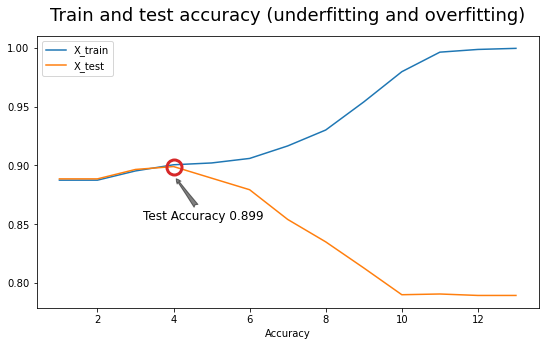

In [19]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(max_depths, accuracies_train_max_depth, label='X_train', zorder=0)
ax.plot(max_depths, accuracies_test_max_depth, label='X_test', zorder=0)

x, y = max_depths[np.argmax(accuracies_test_max_depth)], np.max(accuracies_test_max_depth)

ax.plot([x], [y], color='tab:red', marker='o', markerfacecolor='None', ms=15, markeredgewidth=3, zorder=1)
ax.annotate(text=f'Test Accuracy {np.round(y, 3)}', xy=(x*1.01, y*0.99), xytext=(x*0.8, y*0.95), fontsize=12,
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', color='k', alpha=0.5))

ax.set_title('Train and test accuracy (underfitting and overfitting)', fontsize=18, pad=15)
ax.set_xlabel('Max Depth'), ax.set_xlabel('Accuracy')

ax.legend();

---

### Min Samples Split

Consider the following hyperparameter min_samples_split values: [1, 5, 10, 20, 50].<br>
For each value, we constructed a tree and pruned it according to the min_samples_split value.

In [20]:
min_samples_split = [1, 5, 10, 20, 50, 100]

trees_min_samples = [ID3(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=min_samples) for min_samples in min_samples_split]
accuracies_train_min_samples = [np.mean([predict(node=tree, instance=instance) == instance[-1] for instance in X_train]) for tree in trees_min_samples]
accuracies_test_min_samples = [np.mean([predict(node=tree, instance=instance) == instance[-1] for instance in X_test]) for tree in trees_min_samples]

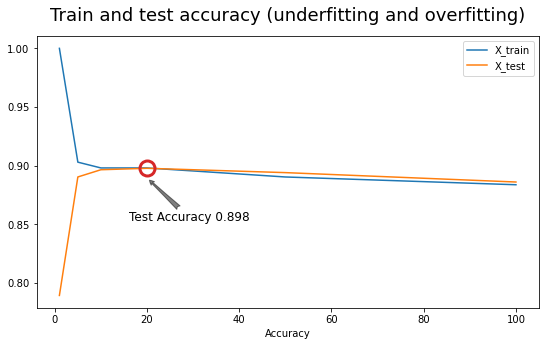

In [21]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(min_samples_split, accuracies_train_min_samples, label='X_train', zorder=0)
ax.plot(min_samples_split, accuracies_test_min_samples, label='X_test', zorder=0)

x, y = min_samples_split[np.argmax(accuracies_test_min_samples)], np.max(accuracies_test_min_samples)

ax.plot([x], [y], color='tab:red', marker='o', markerfacecolor='None', ms=15, markeredgewidth=3, zorder=1)
ax.annotate(text=f'Test Accuracy {np.round(y, 3)}', xy=(x*1.01, y*0.99), xytext=(x*0.8, y*0.95), fontsize=12,
            arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', color='k', alpha=0.5))

ax.set_title('Train and test accuracy (underfitting and overfitting)', fontsize=18, pad=15)
ax.set_xlabel('Max Depth'), ax.set_xlabel('Accuracy')

ax.legend();

Building the best trees in terms of max_depth and min_samples_split:
1. tree_max_depth - the best tree according to max_depth pruning
2. tree_min_samples_split - the best tree according to min_samples_split pruning

In [22]:
tree_max_depth = trees_max_depth[np.argmax(accuracies_test_max_depth)]
tree_min_samples_split = trees_min_samples[np.argmax(accuracies_test_min_samples)]

---

### Exploring tree's structure:

**Utility function which counts recursively the number of nodes of a given tree.**

In [23]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """

    if len(node.children) == 0:
        return 1
    
    return 1 + np.sum([count_nodes(node) for node in node.children])

In [24]:
print('tree_max_depth:', count_nodes(tree_max_depth))
print('tree_min_samples_split:', count_nodes(tree_min_samples_split))

tree_max_depth: 216
tree_min_samples_split: 352


---

**Utility function which prints the tree structure recursively.**

We print the root of the tree, the nodes and the leafs.

In [25]:
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    
    # Preorder traversal
    if node.depth == 0:  # Print the root
        print(f'[ROOT, feature=X{node.decision_attribute}]')
    
    if node.children != []:
        for child, name in zip(node.children, node.children_names):
            if len(child.children) != 0:  # is not a leaf
                print(' ' * 4 * child.depth + f'[X{node.decision_attribute}={name}, feature={child.decision_attribute}]')
                print_tree(child)
            else:
                print(' ' * 4 * child.depth + f'[X{node.decision_attribute}={name}, leaf]: [{child.target_counts}]')

In [26]:
print_tree(tree_max_depth)

[ROOT, feature=X4]
    [X4=a, feature=2]
        [X2=n, feature=8]
            [X8=n, feature=19]
                [X19=s, leaf]: [{'e': 5, 'p': 3}]
                [X19=y, leaf]: [{'e': 8}]
            [X8=p, feature=0]
                [X0=f, leaf]: [{'e': 2, 'p': 1}]
                [X0=x, leaf]: [{'e': 7}]
            [X8=w, feature=18]
                [X18=k, leaf]: [{'e': 5, 'p': 1}]
                [X18=n, leaf]: [{'e': 7}]
        [X2=w, feature=6]
            [X6=c, feature=20]
                [X20=g, leaf]: [{'e': 48, 'p': 2}]
                [X20=m, leaf]: [{'e': 45, 'p': 6}]
            [X6=w, leaf]: [{'e': 21}]
        [X2=y, feature=6]
            [X6=c, feature=8]
                [X8=g, leaf]: [{'e': 24, 'p': 3}]
                [X8=k, leaf]: [{'e': 23, 'p': 1}]
                [X8=n, leaf]: [{'e': 33, 'p': 7}]
                [X8=p, leaf]: [{'e': 15}]
                [X8=w, leaf]: [{'e': 33, 'p': 6}]
            [X6=w, feature=0]
                [X0=f, leaf]: [{'e': 7, 'p

---